In [ ]:
import subprocess
import sys

def install(package, upgrade=False):
    try:
        command = [sys.executable, "-m", "pip", "install"]
        if upgrade:
            command.append("--upgrade")
        command.append(package)
        subprocess.check_call(command)
    except subprocess.CalledProcessError as e:
        print(f"Error installing package {package}: {e}")

install("pip", upgrade=True)
install("setuptools", upgrade=True)

# Required packages
required_packages = [
    "uproot", "awkward", "coffea", "qkeras",
    "tensorflow-model-optimization", "umap-learn",
    "numpy", "pandas", "matplotlib", "scikit-learn",
    "minisom"
]

for package in required_packages:
    install(package)


In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Concatenate
from qkeras import QActivation, QConv2D, QDense, quantized_bits
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import glob
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
from sklearn.cluster import KMeans, DBSCAN
import umap
import scipy

# Configure seed for reproducability
np.random.seed(42)

# Necessary later for Tensor Flow to evaluate operations immediately instead of with graph execution
tf.config.run_functions_eagerly(True)

In [ ]:
# Custom layers defined in the original Convolutional Autoencoder (CAE)

class KerasPaddingLayer(tf.keras.layers.Layer):
    def call(self, x):
        padding = tf.constant([[0, 0], [0, 1], [0, 1], [0, 0]]) #pad height and width with 1 row/column.
        return tf.pad(x, padding, mode='CONSTANT', constant_values=0)

    def compute_output_shape(self, input_shape):
        batch_size, height, width, channels = input_shape #increase height and width by 1 -- keep other dimensions the same
        return (batch_size, height + 1, width + 1, channels)


class KerasMinimumLayer(tf.keras.layers.Layer):
    def __init__(self, saturation_value=1, **kwargs):
        super(KerasMinimumLayer, self).__init__(**kwargs)
        self.saturation_value = saturation_value

    def call(self, x):
        return tf.minimum(x, self.saturation_value) #cap values at saturation_value

    def compute_output_shape(self, input_shape):
        return input_shape


class KerasFloorLayer(tf.keras.layers.Layer):
    def call(self, x):
        return tf.math.floor(x) #round down each element

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
# Load ROOT Files
def load_root_files(file_limit=-1, selected_eLinks=-1):
    files = glob.glob('*.root')
    if file_limit > 0:
        files = files[:file_limit] #limit the number of files if desired

    all_inputs, all_conditions = [], []
    tree_name = 'FloatingpointThreshold0DummyHistomaxDummynTuple/HGCalTriggerNtuple'

    for file_index, file in enumerate(files):
        print(f"Processing file {file_index + 1}/{len(files)}: {file}")
        try:
            with uproot.open(file) as root_file:
                if tree_name not in root_file:
                    raise ValueError(f"Tree '{tree_name}' not found in file '{file}'")
                tree = root_file[tree_name]

                # Branches needed from the TTree
                branches = [
                    "gen_pt", "wafer_layer", "wafer_eta", "wafer_waferv",
                    "wafer_waferu", "wafer_wafertype"
                ]
                branches.extend([f"wafer_CALQ{j}" for j in range(64)])
                branches.extend([f"wafer_AEin{j}" for j in range(64)])

                data = tree.arrays(branches, library="ak") #load branches into awkward array
                mask = (ak.mean(data["gen_pt"], axis=1) >= 0) & (ak.mean(data["gen_pt"], axis=1) <= 100000) #filter ensuring all gen_pt events are non-negative and have an upper threshold
                data = data[mask]

                # Extract, preprocess, and normalize data from the awkward array
                layers = ak.to_numpy(ak.flatten(data["wafer_layer"]))
                eta = ak.to_numpy(ak.flatten(data["wafer_eta"])) / 3.1
                wafer_v = ak.to_numpy(ak.flatten(data["wafer_waferv"])) / 12
                wafer_u = ak.to_numpy(ak.flatten(data["wafer_waferu"])) / 12
                wafer_type = ak.to_numpy(ak.flatten(data["wafer_wafertype"])).astype(int)
                one_hot_wafertype = np.eye(np.max(wafer_type) + 1)[wafer_type] #one-hot encode wafer type

                sum_CALQ = np.sum([ak.to_numpy(ak.flatten(data[f"wafer_CALQ{j}"])) for j in range(64)], axis=0)
                sum_CALQ = np.log(sum_CALQ + 1) #apply log transformation

                # Stack AEin values into 8x8 inputs
                inputs = np.stack([ak.to_numpy(ak.flatten(data[f"wafer_AEin{j}"])) for j in range(64)], axis=-1)
                inputs = np.reshape(inputs, (-1, 8, 8))

                # Apply eLinks selection mask
                selection_mask = {
                    5: (layers <= 11) & (layers >= 5),
                    4: (layers == 7) | (layers == 11),
                    3: (layers == 13),
                    2: (layers < 7) | (layers > 13),
                    -1: (layers > 0)
                }[selected_eLinks]

                inputs = inputs[selection_mask]
                eta = eta[selection_mask]
                wafer_v = wafer_v[selection_mask]
                wafer_u = wafer_u[selection_mask]
                one_hot_wafertype = one_hot_wafertype[selection_mask]
                sum_CALQ = sum_CALQ[selection_mask]
                layers_normalized = (layers[selection_mask] - 1) / 46

                # Stack all condition features into a single array
                conditions = np.hstack([
                    eta[:, np.newaxis], wafer_v[:, np.newaxis], wafer_u[:, np.newaxis],
                    one_hot_wafertype, sum_CALQ[:, np.newaxis], layers_normalized[:, np.newaxis]
                ])

                all_inputs.append(inputs)
                all_conditions.append(conditions)

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if not all_inputs:
        raise ValueError("No data was loaded. Please check your ROOT files and tree names.")

    # Concatenate inputs and conditions
    return np.concatenate(all_inputs), np.concatenate(all_conditions)

In [ ]:
# Encoder Model Setup
class EncoderModelBuilder:
    @staticmethod
    def build_encoder_model():
        input_shape = (8, 8, 1) #shape of the wafer input
        condition_shape = (8,) #shape of the condition input

        # Encoder inputs
        wafer_input = Input(shape=input_shape, name='Wafer_Input')
        condition_input = Input(shape=condition_shape, name='Condition_Input')

        # Encoder architecture
        x = QActivation(activation=quantized_bits(bits=8, integer=1), name='Input_Quantization')(wafer_input)
        x = KerasPaddingLayer()(x)
        x = QConv2D(
            filters=8, kernel_size=3, strides=2, padding='valid',
            kernel_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
            bias_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
            name='Conv2D'
        )(x)
        x = QActivation(activation=quantized_bits(bits=8, integer=1), name='Activation')(x)
        x = Flatten()(x)
        x = QDense(
            units=16,
            kernel_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
            bias_quantizer=quantized_bits(bits=6, integer=0, keep_negative=1, alpha=1),
            name='Dense_Layer'
        )(x)
        x = QActivation(activation=quantized_bits(bits=9, integer=1), name='Latent_Quantization')(x)
        latent_output = x

        # Optional quantization steps -- this can further refine the latent vector
        bits_per_output = 9
        if bits_per_output > 0:
            n_integer_bits = 1
            n_decimal_bits = bits_per_output - n_integer_bits
            output_max_int_size = 1 << n_decimal_bits
            output_saturation_value = (1 << n_integer_bits) - 1. / (1 << n_decimal_bits)

            latent_output = KerasFloorLayer()(latent_output * output_max_int_size)
            latent_output = KerasMinimumLayer(saturation_value=output_saturation_value)(latent_output / output_max_int_size)

        latent_output = Concatenate(axis=1)([latent_output, condition_input])

        # Build and return the encoder model
        encoder = Model(inputs=[wafer_input, condition_input], outputs=latent_output, name='Encoder_Model')
        return encoder

encoder = EncoderModelBuilder.build_encoder_model()
encoder.summary()

# Loads in the pre-trained weights from the original CAE
encoder.load_weights('encoder_vanilla_AE_eLink5.hdf5')

In [31]:
# Calculate latent representations
batch_size = 128

inputs, conditions = load_root_files(file_limit=-1)
inputs = np.expand_dims(inputs, axis=-1) #expand dimensions to match expected shape (8, 8, 1)
latent_representations = encoder.predict([inputs, conditions], batch_size) #predict latent representations from inputs and conditions

Processing file 1/7: ntuple_2.root
Error processing file ntuple_2.root: expected Chunk of length 204,
received 0 bytes from FSSpecSource
for file path /content/ntuple_2.root
Processing file 2/7: ntuple_72.root
Error processing file ntuple_72.root: expected Chunk of length 204,
received 0 bytes from FSSpecSource
for file path /content/ntuple_72.root
Processing file 3/7: ntuple_125.root
Error processing file ntuple_125.root: expected Chunk of length 204,
received 0 bytes from FSSpecSource
for file path /content/ntuple_125.root
Processing file 4/7: ntuple_123.root
Error processing file ntuple_123.root: expected Chunk of length 204,
received 0 bytes from FSSpecSource
for file path /content/ntuple_123.root
Processing file 5/7: ntuple_133.root
Error processing file ntuple_133.root: expected Chunk of length 204,
received 0 bytes from FSSpecSource
for file path /content/ntuple_133.root
Processing file 6/7: ntuple_20.root
Error processing file ntuple_20.root: not a ROOT file: first four bytes a

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


 199/8072 ━━━━━━━━━━━━━━━━━━━━ 3:43 28ms/step

KeyboardInterrupt: 

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


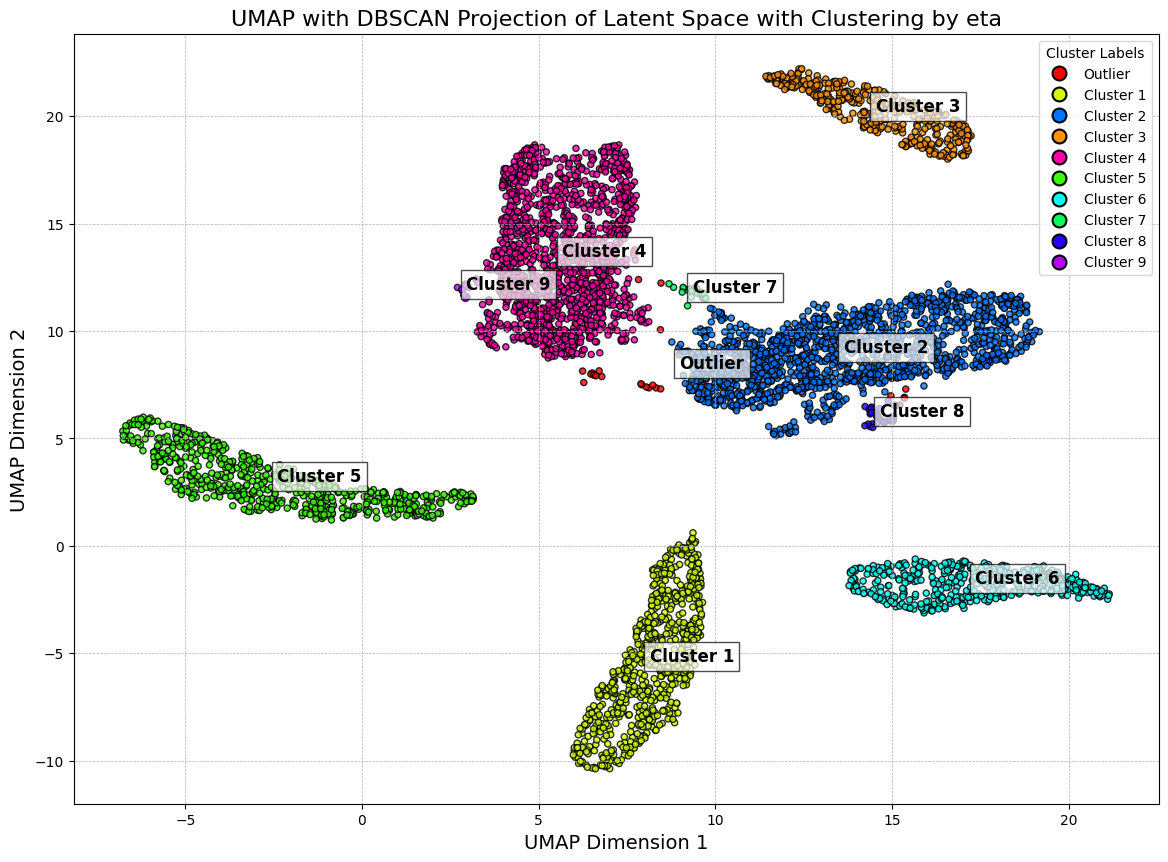

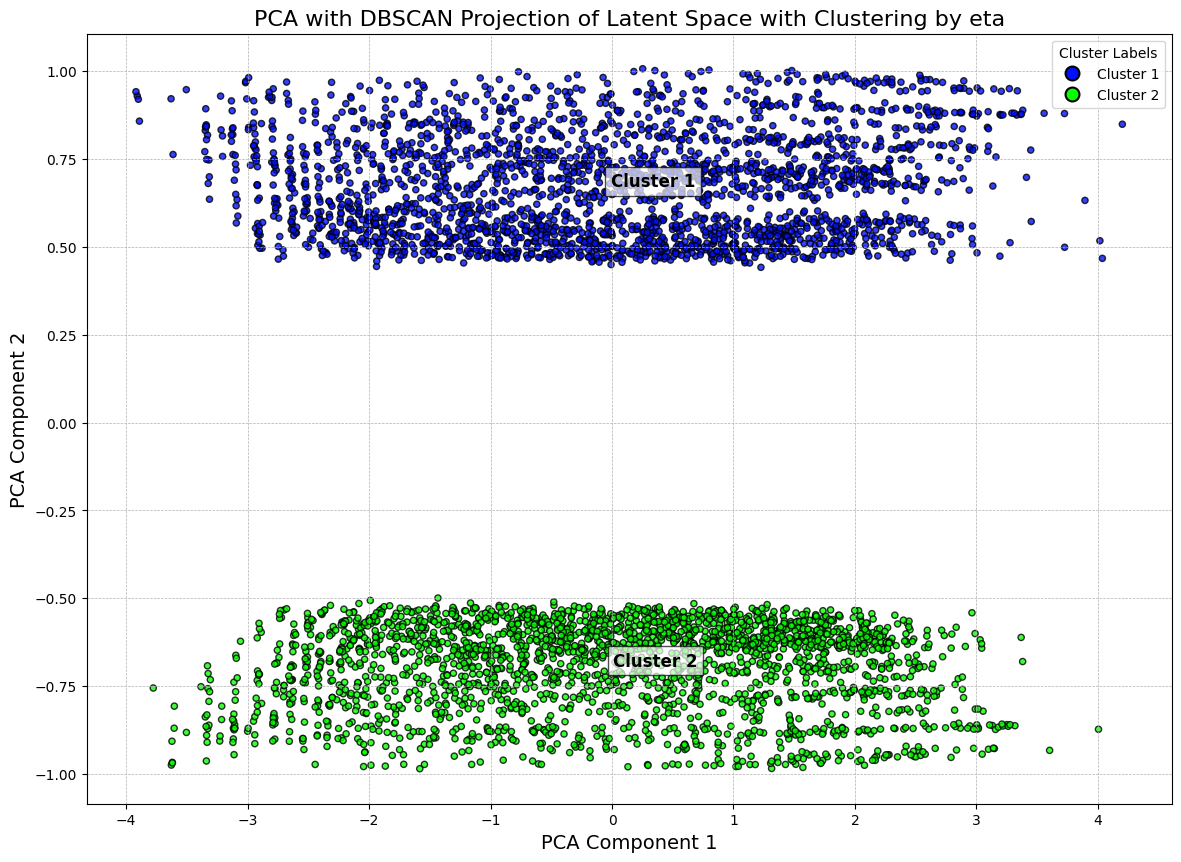

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


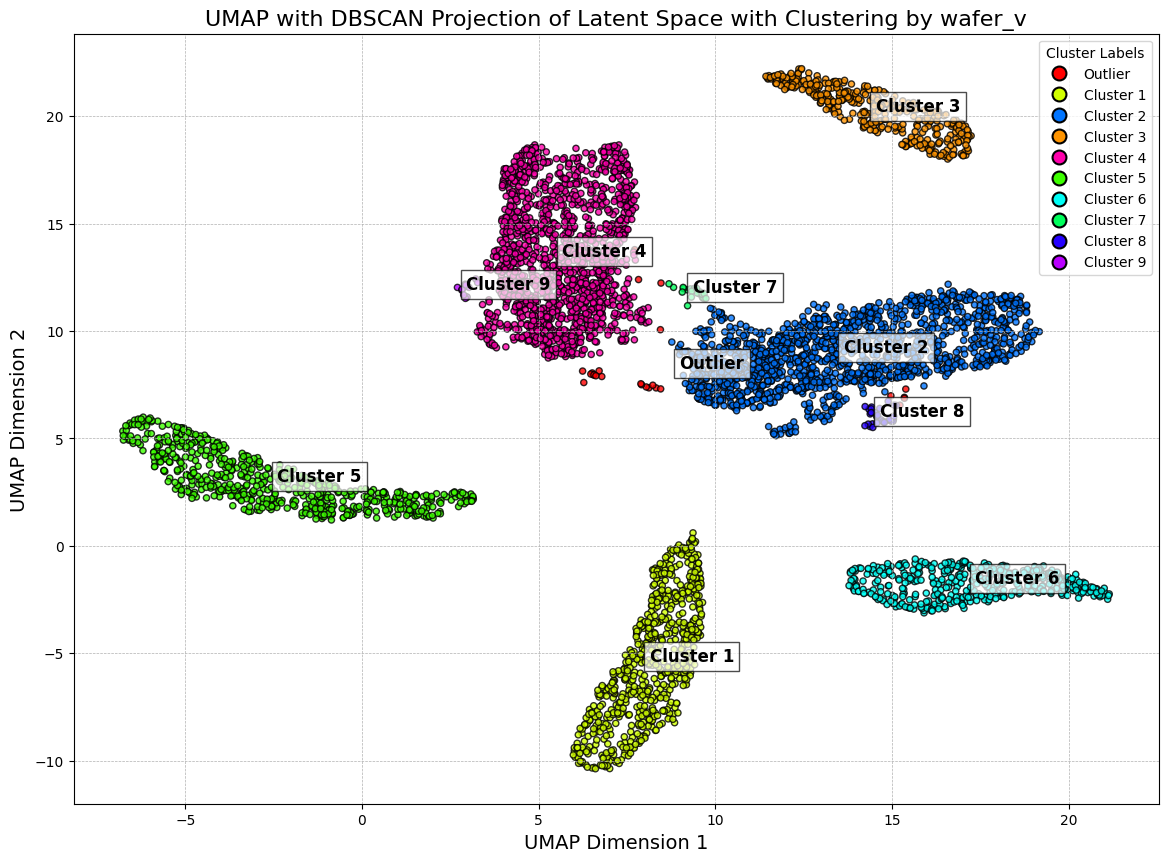

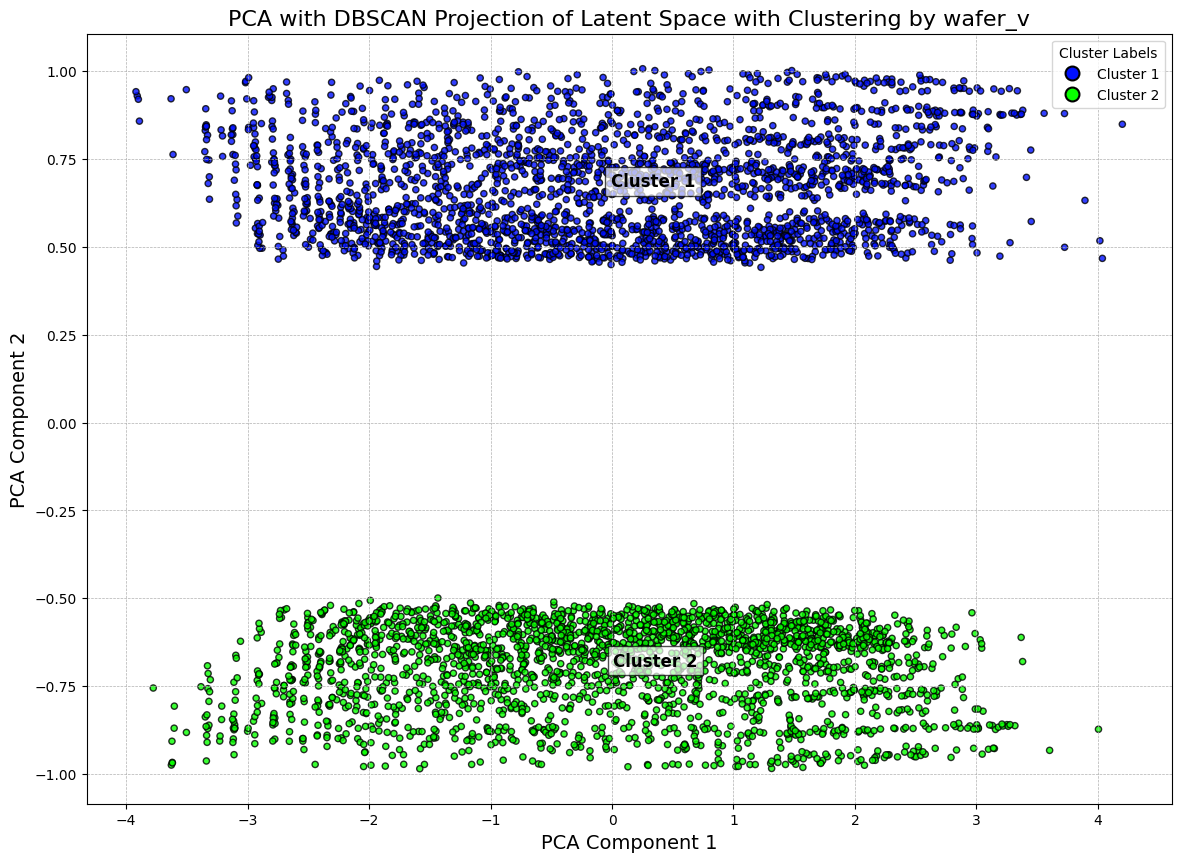

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


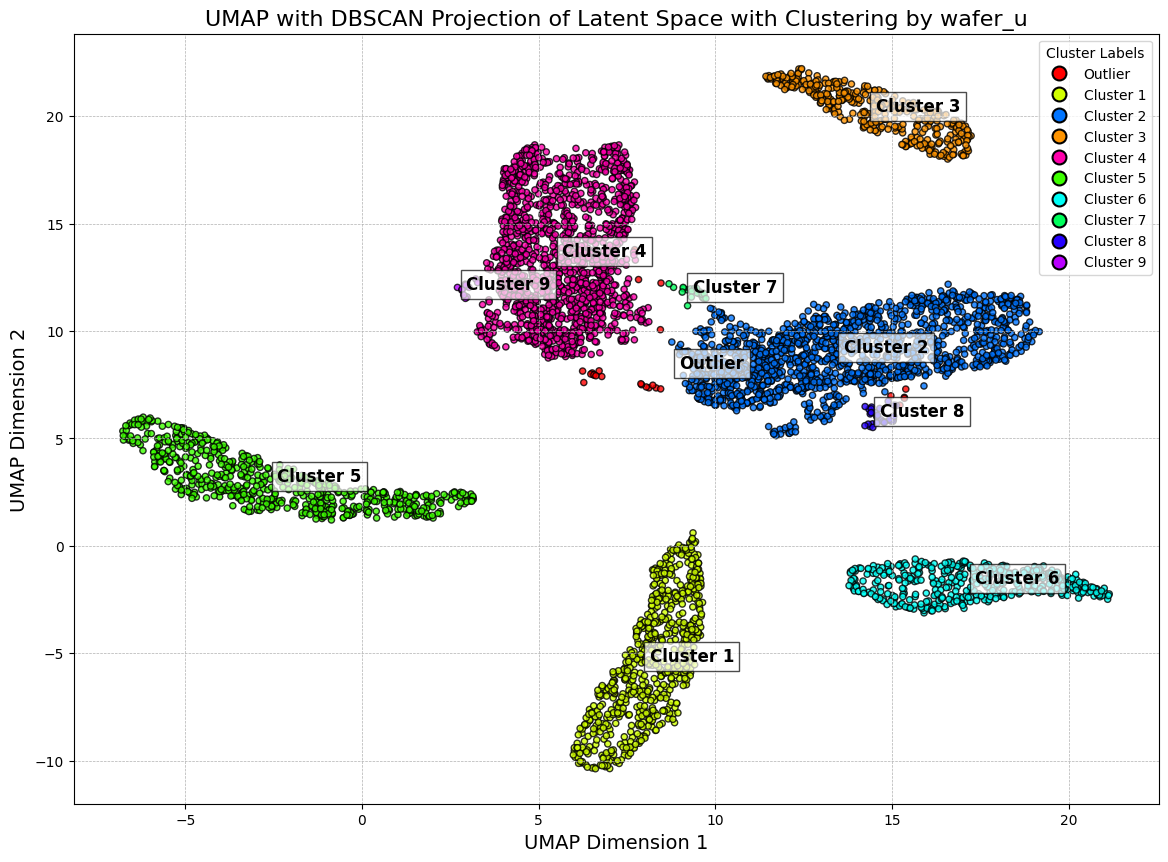

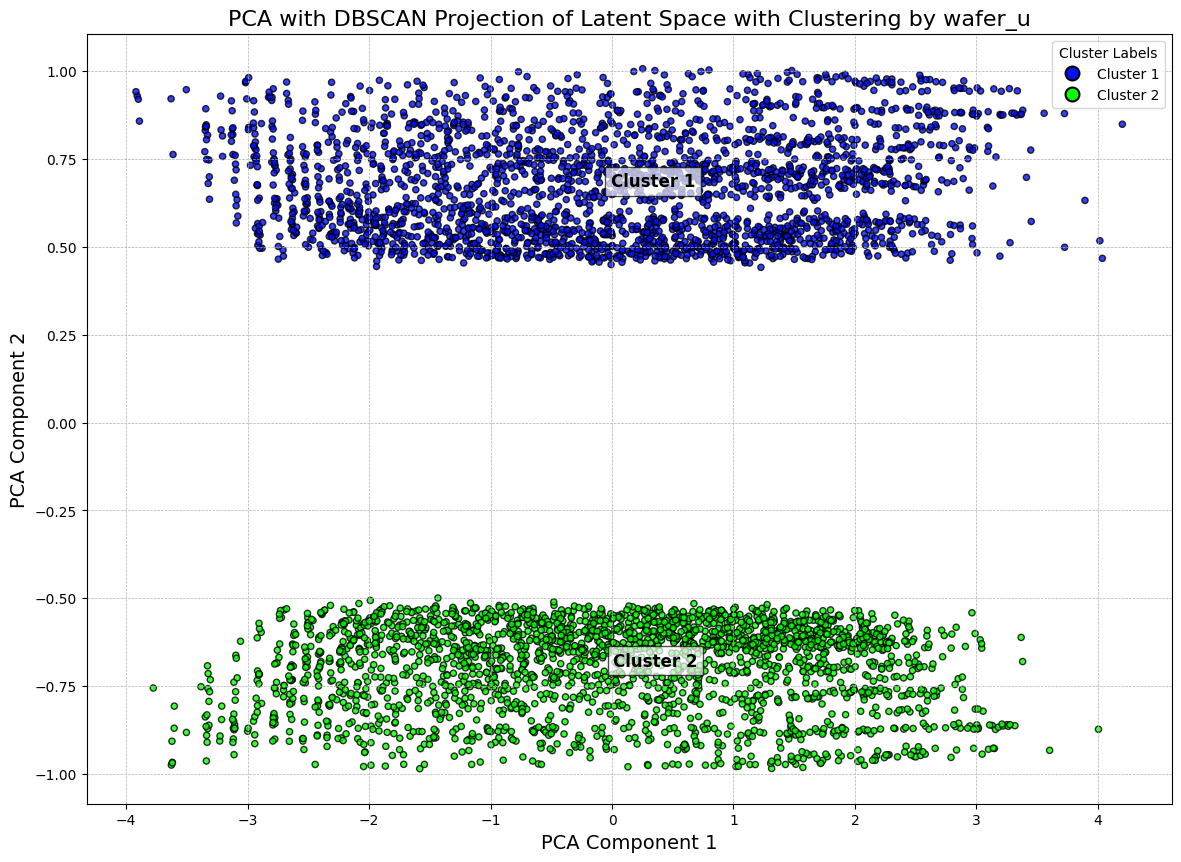

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


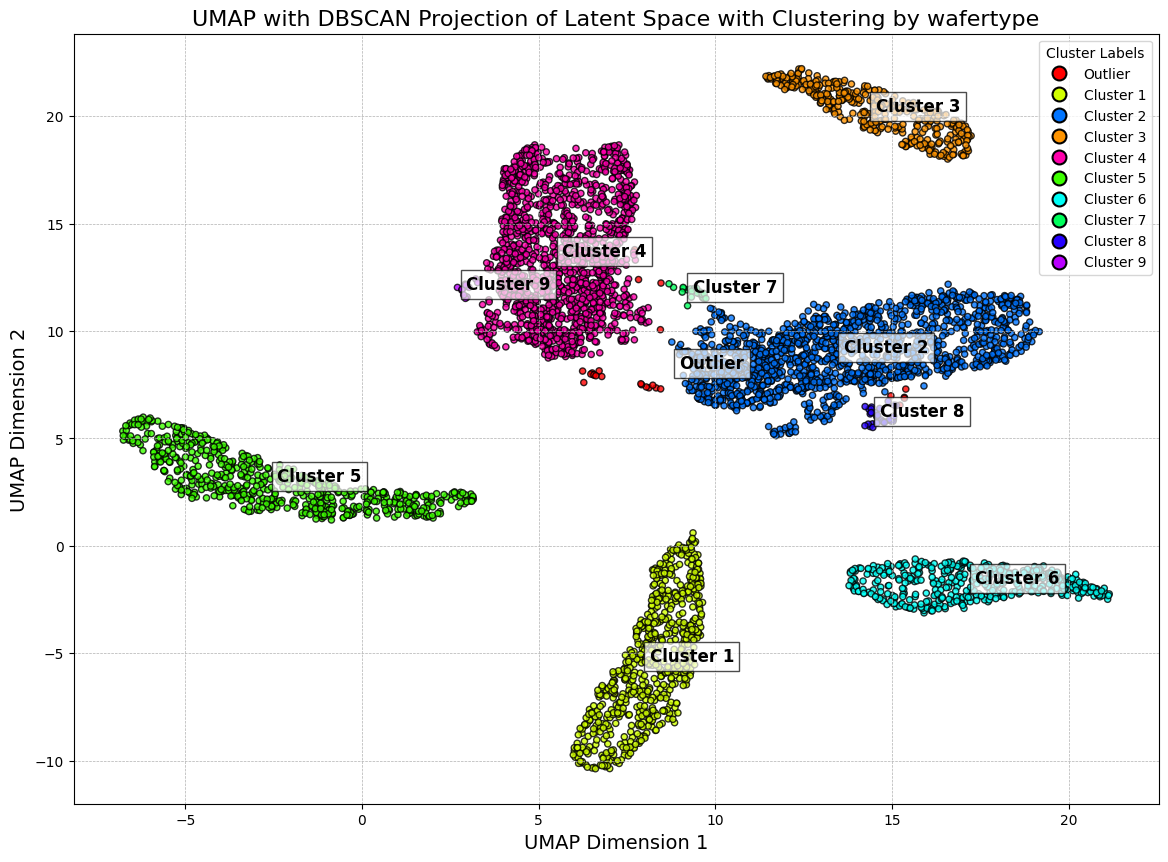

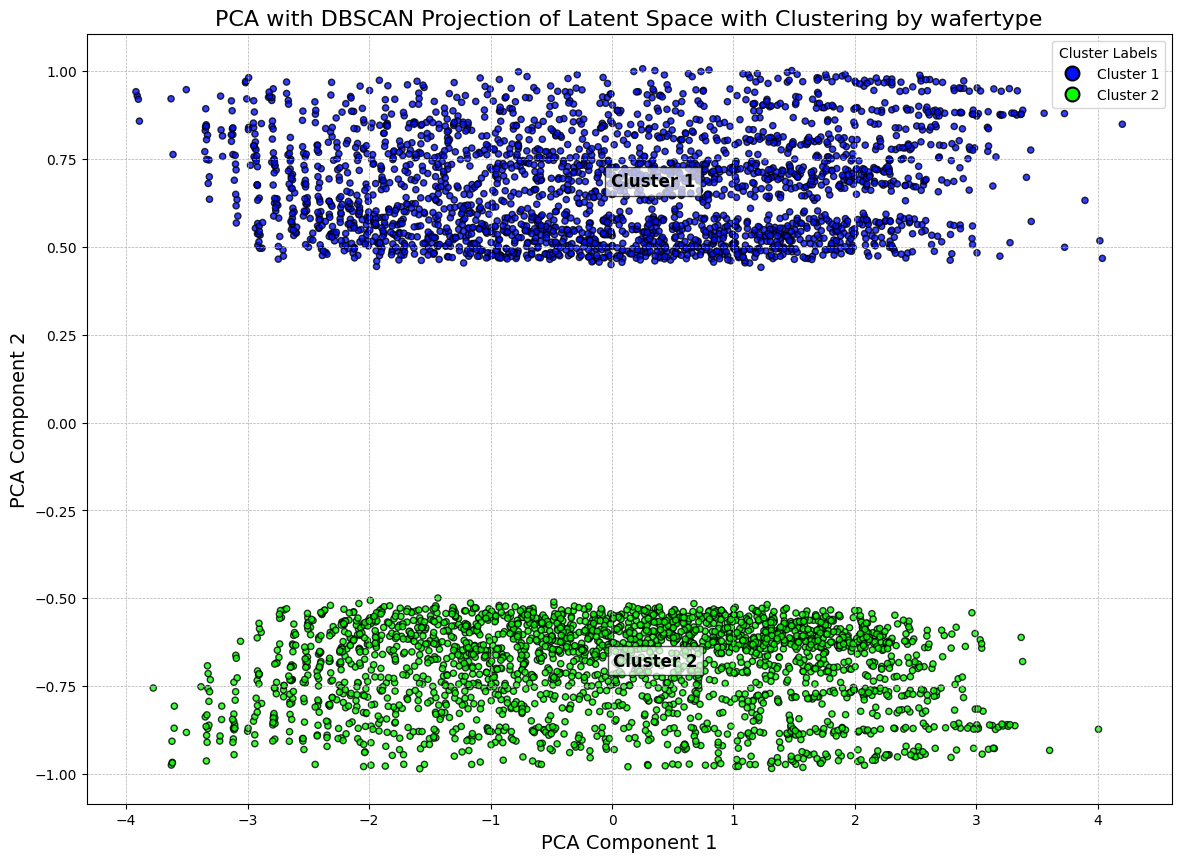

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


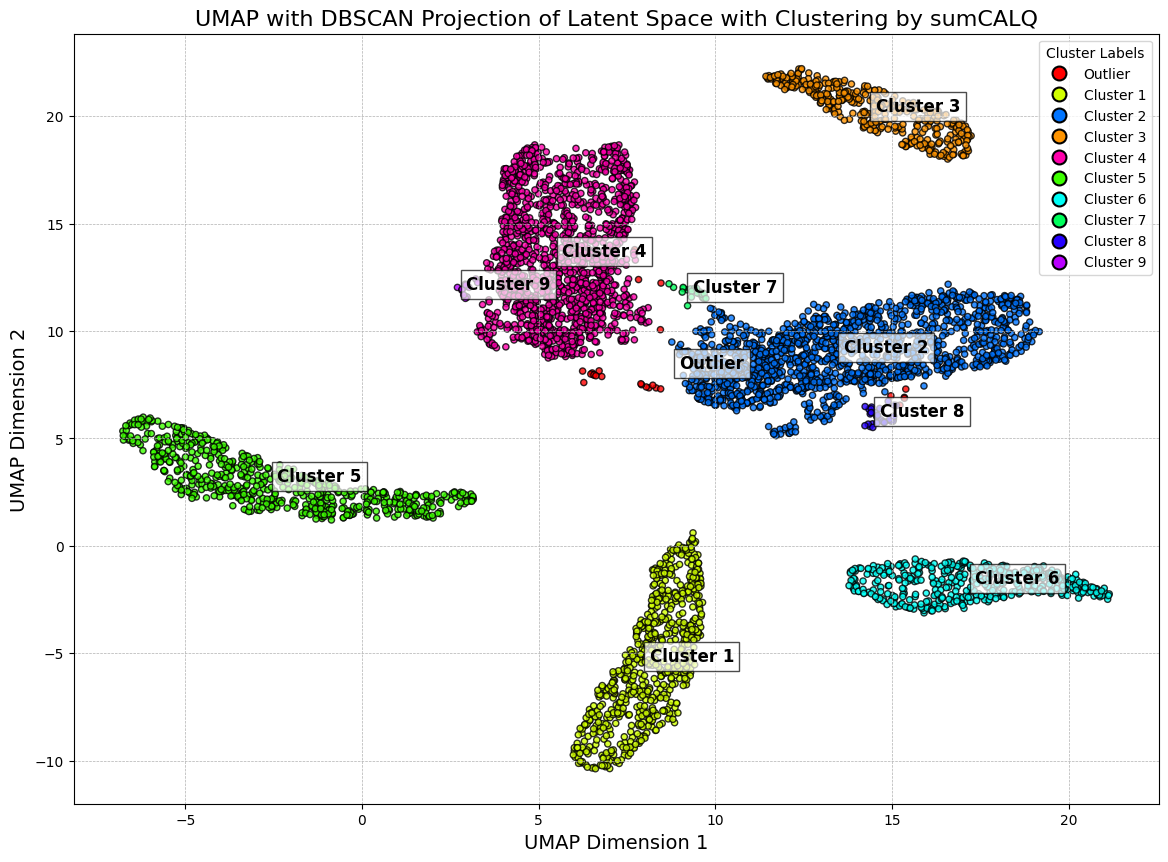

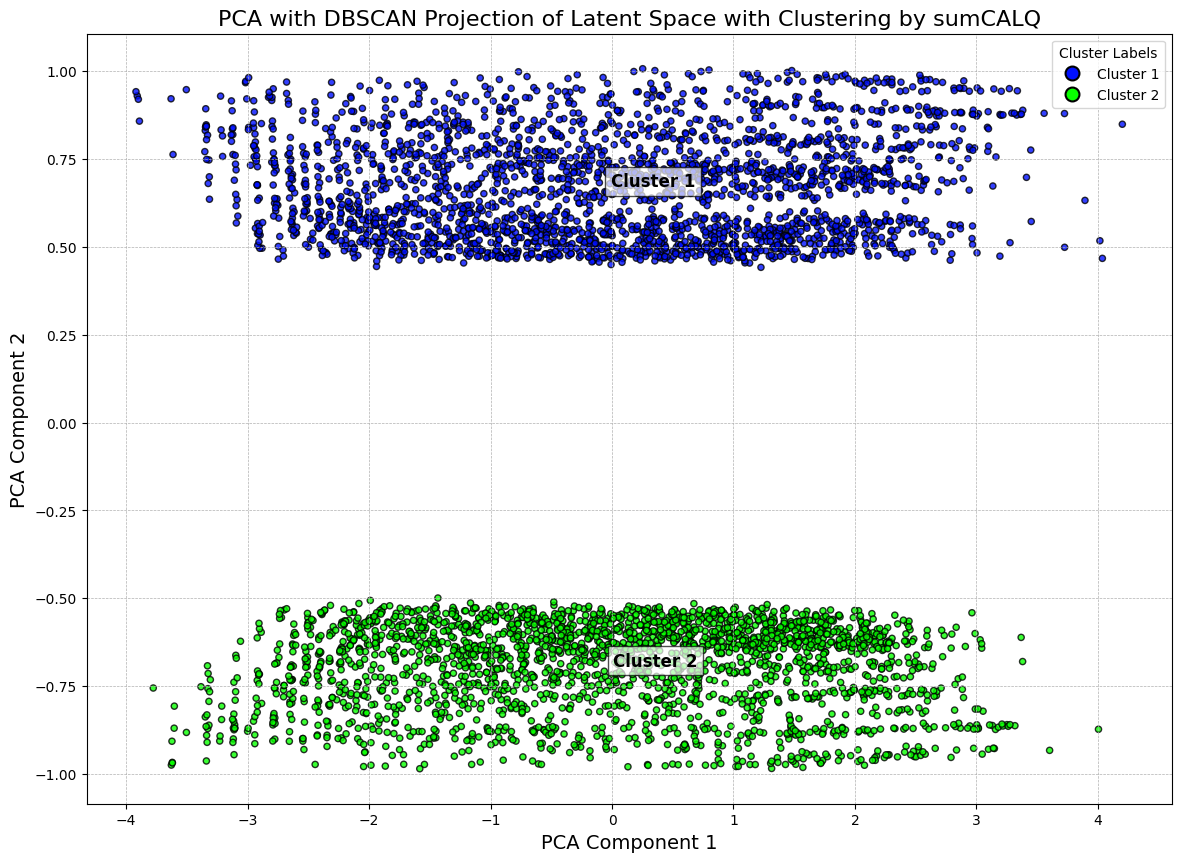

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


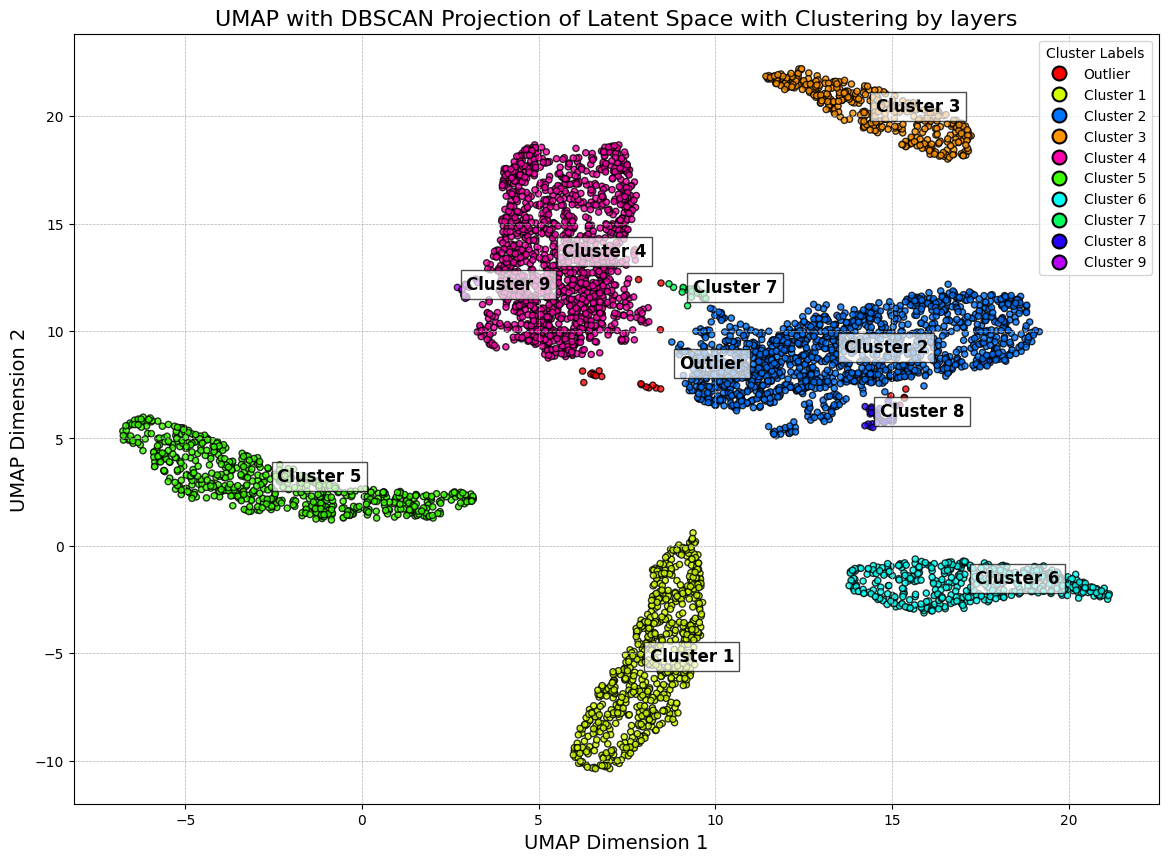

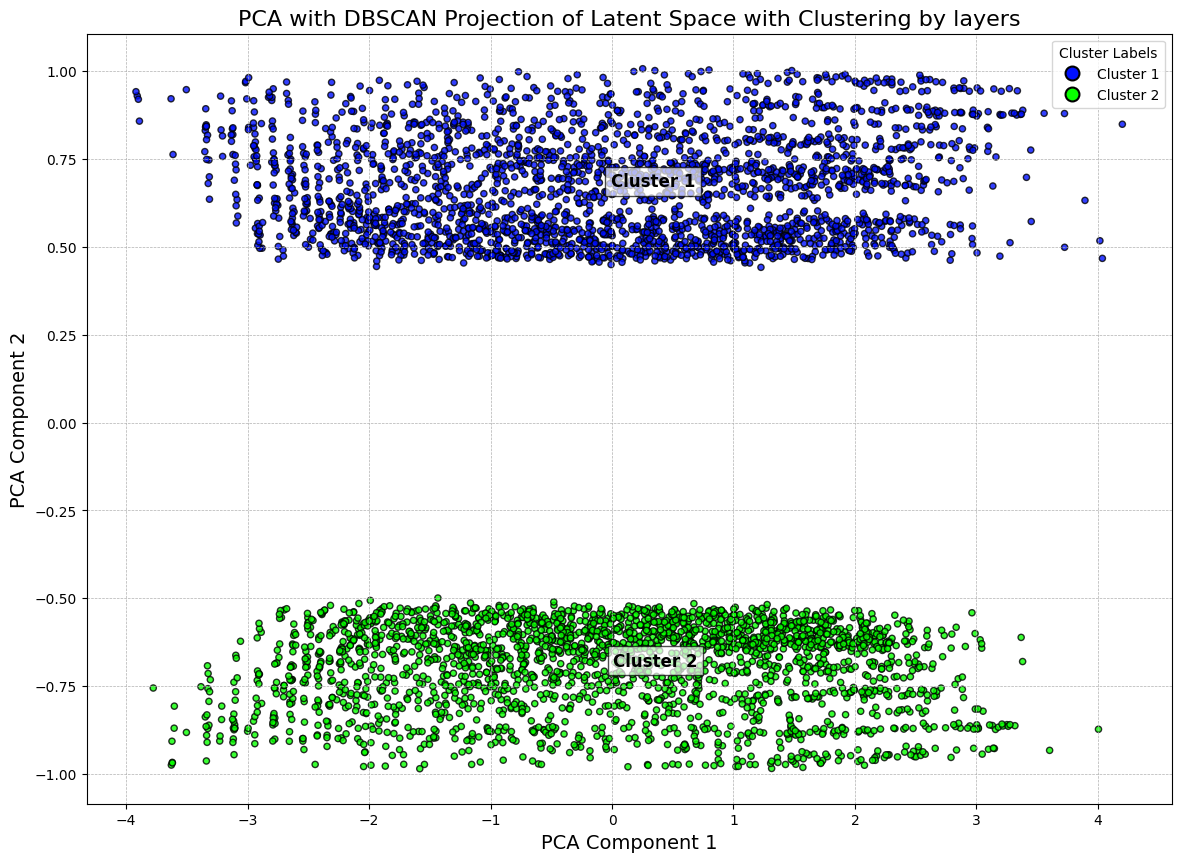

In [30]:
from minisom import MiniSom
import seaborn as sns

# Extract variables from conditions matrix
total_cond_dim = conditions.shape[1]
wafertype_start = 3
wafertype_end = wafertype_start + 3
sumCALQ_index = wafertype_end
layers_index = sumCALQ_index + 1

# Extract individual attributes
eta = conditions[:, 0]
waferv = conditions[:, 1]
waferu = conditions[:, 2]
wafertype_onehot = conditions[:, wafertype_start:wafertype_end]
sumCALQ = conditions[:, sumCALQ_index]
layers = conditions[:, layers_index]

# Plot latent space representations
def plot_latent_space(latent_sample, attribute_sample, attribute_name, technique_name, embedding, component_labels, cluster_labels=None):
    plt.figure(figsize=(14, 10))

    if cluster_labels is not None:
        unique_labels = np.unique(cluster_labels)
        if len(unique_labels) > 1:
            non_outlier_labels = [label for label in unique_labels if label != -1]
            palette = sns.color_palette('hsv', len(non_outlier_labels))
            np.random.seed(42)  # Set seed for reproducibility
            shuffled_palette = np.random.permutation(palette)
        else:
            shuffled_palette = sns.color_palette('hsv', 1)

        color_map = {}

        # Assign colors to clusters, ensuring cluster -1 (outliers) is bright red
        for i, label in enumerate(unique_labels):
            if label == -1:
                color_map[label] = '#FF0000'  # Bright red for outliers
            else:
                color_map[label] = shuffled_palette[i % len(shuffled_palette)]

        # Map cluster labels to colors
        colors = [color_map[label] for label in cluster_labels]

        # Scatter plot with cluster labels
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=20, alpha=0.8, edgecolor='k')
        for label in unique_labels:
            if label != -1:
                x_text = np.mean(embedding[cluster_labels == label, 0])
                y_text = np.mean(embedding[cluster_labels == label, 1])
                plt.text(x_text, y_text, f'Cluster {label + 1}', fontsize=12, weight='bold',
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))
            else:
                x_text = np.mean(embedding[cluster_labels == label, 0])
                y_text = np.mean(embedding[cluster_labels == label, 1])
                plt.text(x_text, y_text, f'Outlier', fontsize=12, weight='bold',
                         bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

        # Title and legend
        plt.title(f'{technique_name} Projection of Latent Space with Clustering by {attribute_name}', fontsize=16)
        handles = [
            plt.Line2D([0], [0], marker='o', color='w', label='Outlier', markersize=10,
                       markerfacecolor='#FF0000', markeredgewidth=1.5, markeredgecolor='k') if label == -1 else
            plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label + 1}', markersize=10,
                       markerfacecolor=color_map[label], markeredgewidth=1.5, markeredgecolor='k')
            for label in unique_labels
        ]
        plt.legend(handles=handles, title='Cluster Labels', loc='best')

    else:
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=attribute_sample, s=20, cmap='viridis', alpha=0.8, edgecolor='k')
        plt.title(f'{technique_name} Projection of Latent Space Colored by {attribute_name}', fontsize=16)
        plt.colorbar(scatter, label=attribute_name, shrink=0.8)

    plt.xlabel(component_labels[0], fontsize=14)
    plt.ylabel(component_labels[1], fontsize=14)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()

attributes = {
    'eta': eta,
    'wafer_v': waferv,
    'wafer_u': waferu,
    'wafertype': np.argmax(wafertype_onehot, axis=1),
    'sumCALQ': sumCALQ,
    'layers': layers
}

# Sample a subset of latent representations
num_samples = 5000
sample_indices = np.random.choice(len(latent_representations), num_samples, replace=False)
latent_sample = latent_representations[sample_indices]

# Or use entire set
#latent_sample = latent_representations

for attribute_name, attribute_values in attributes.items():
    attribute_sample = attribute_values[sample_indices]

    # Hybrid approach using UMAP with DBSCAN
    umap_reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, metric='euclidean', random_state=42) #change n_neighbors to emphasize a local or global set
    umap_embedding = umap_reducer.fit_transform(latent_sample)
    dbscan = DBSCAN(eps=0.5, min_samples=10)
    dbscan_labels = dbscan.fit_predict(umap_embedding)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 'UMAP with DBSCAN', umap_embedding, ['UMAP Dimension 1', 'UMAP Dimension 2'], cluster_labels=dbscan_labels)

    # Hybrid approach using PCA with DBSCAN
    dim_reducer_pca = PCA(n_components=2)
    pca_embedding = dim_reducer_pca.fit_transform(latent_sample)
    dbscan_pca = DBSCAN(eps=0.5, min_samples=10)
    dbscan_pca_labels = dbscan_pca.fit_predict(pca_embedding)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 'PCA with DBSCAN', pca_embedding, ['PCA Component 1', 'PCA Component 2'], cluster_labels=dbscan_pca_labels)

In [ ]:
for attribute_name, attribute_values in attributes.items():
    attribute_sample = attribute_values[sample_indices]

    # PCA
    dim_reducer_pca = PCA(n_components=2)
    pca_embedding = dim_reducer_pca.fit_transform(latent_sample)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 'PCA', pca_embedding, ['PCA Component 1', 'PCA Component 2'])

    # t-SNE
    tsne_reducer = TSNE(n_components=2, random_state=42)
    tsne_embedding = tsne_reducer.fit_transform(latent_sample)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 't-SNE', tsne_embedding, ['t-SNE Dimension 1', 't-SNE Dimension 2'])

    # UMAP
    umap_reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, metric='euclidean', random_state=42)
    umap_embedding = umap_reducer.fit_transform(latent_sample)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 'UMAP', umap_embedding, ['UMAP Dimension 1', 'UMAP Dimension 2'])

    # Isomap
    isomap_reducer = Isomap(n_components=2)
    isomap_embedding = isomap_reducer.fit_transform(latent_sample)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 'Isomap', isomap_embedding, ['Isomap Dimension 1', 'Isomap Dimension 2'])

    # Spectral Embedding
    spectral_embedder = SpectralEmbedding(n_components=2, random_state=42)
    spectral_embedding = spectral_embedder.fit_transform(latent_sample)
    plot_latent_space(latent_sample, attribute_sample, attribute_name, 'Spectral Embedding', spectral_embedding, ['Spectral Dimension 1', 'Spectral Dimension 2'])

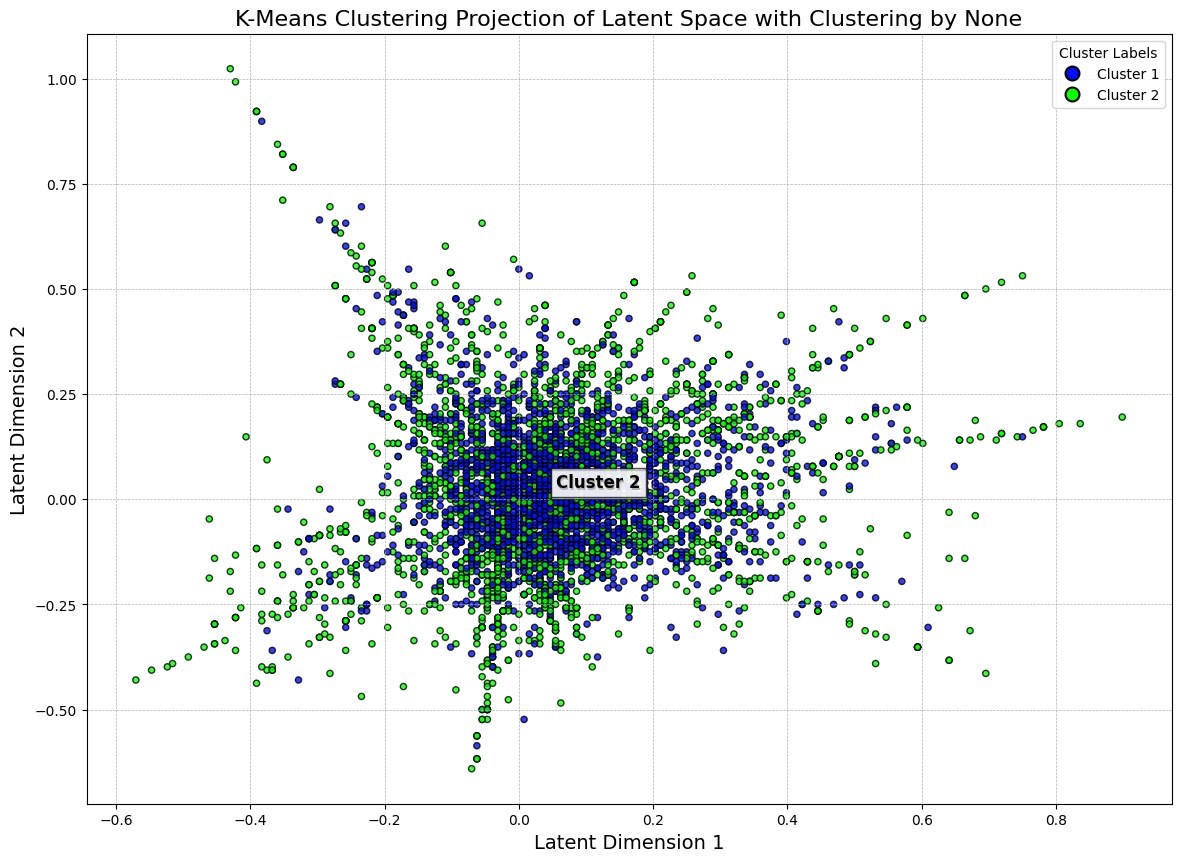

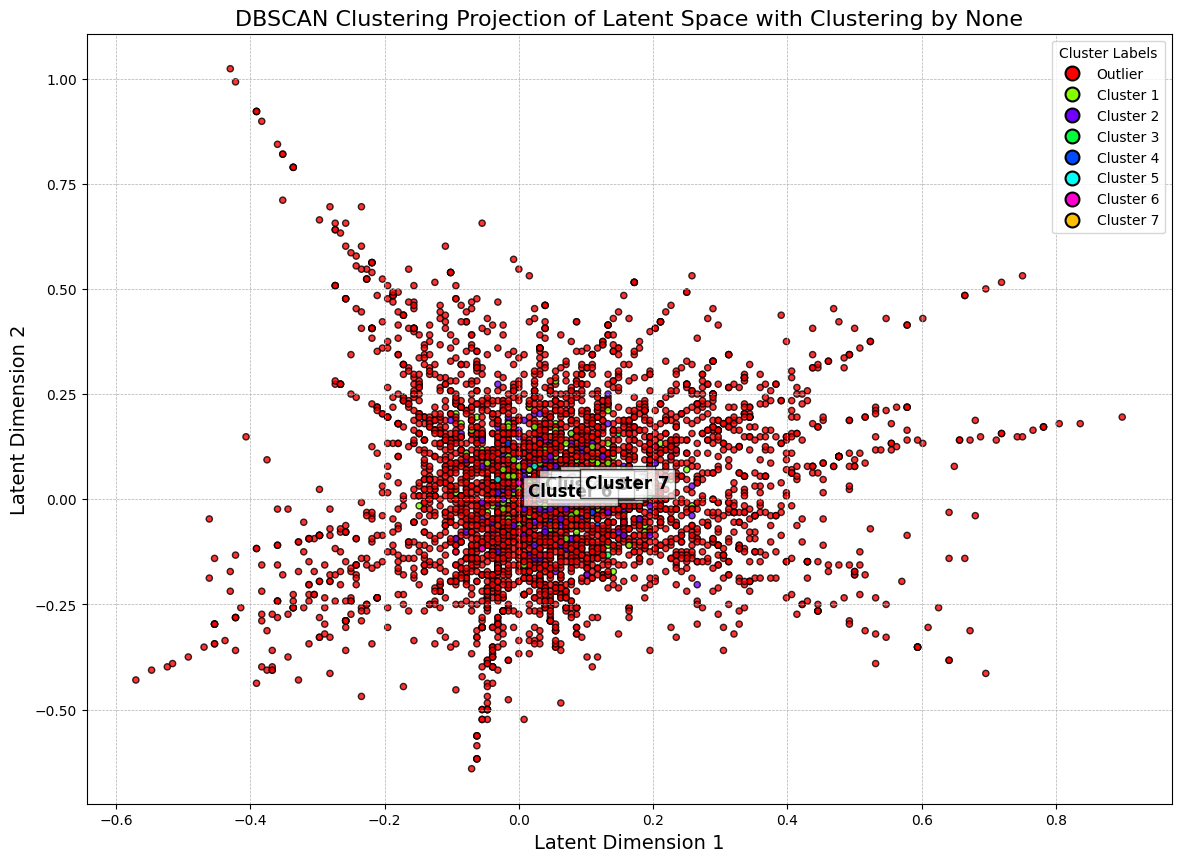

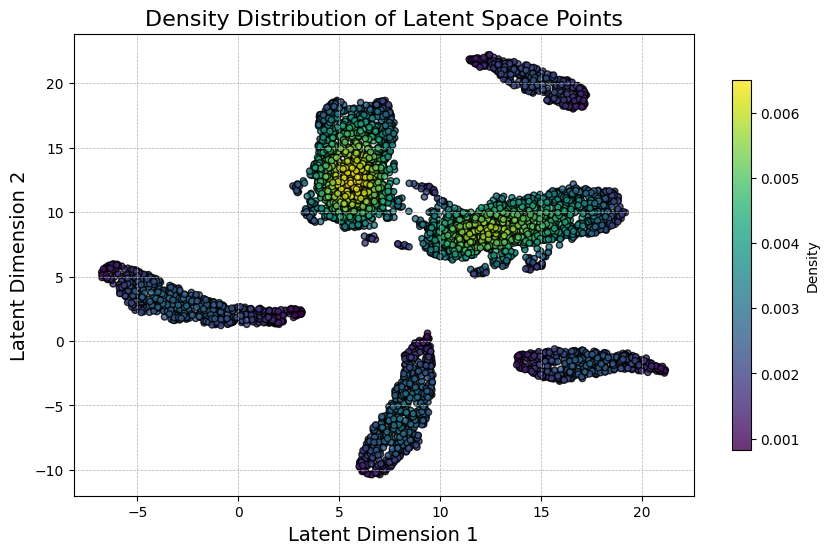

In [34]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(latent_sample)

dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(latent_sample)

# K-Means
plot_latent_space(latent_sample, None, None, 'K-Means Clustering', latent_sample[:, :2], ['Latent Dimension 1', 'Latent Dimension 2'], cluster_labels=kmeans_labels)

# DBSCAN
plot_latent_space(latent_sample, None, None, 'DBSCAN Clustering', latent_sample[:, :2], ['Latent Dimension 1', 'Latent Dimension 2'], cluster_labels=dbscan_labels)

def plot_density_distribution(latent_sample):
    plt.figure(figsize=(10, 6))
    x, y = latent_sample[:, 0], latent_sample[:, 1]
    kde = scipy.stats.gaussian_kde([x, y])
    density = kde([x, y])
    plt.scatter(x, y, c=density, s=20, cmap='viridis', alpha=0.8, edgecolor='k')
    plt.title('Density Distribution of Latent Space Points', fontsize=16)
    plt.colorbar(label='Density', shrink=0.8)
    plt.xlabel('Latent Dimension 1', fontsize=14)
    plt.ylabel('Latent Dimension 2', fontsize=14)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.show()
plot_density_distribution(umap_reducer.fit_transform(latent_sample))
